In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot12DimsNS_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
num_paths = 10240
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
config = get_config()

In [3]:
def get_drift_files(config, root_dir):
    ts_type = f"{config.ndims}DDims"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/12DDimsNS/"
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        print(file)
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [4]:
true_files, local_files, bws = get_drift_files(config=config, root_dir=root_dir)
local_files

IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0024046bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0031749bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0024046bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0018211bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0031749bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_local_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0031749bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_true_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0018211bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_true_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0024046bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_true_states.npy
IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0018211bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy


['/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDimsNS/IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0018211bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDimsNS/IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0024046bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy',
 '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/Nadaraya/12DDimsNS/IIDNadaraya_fBiPot_12DDimsNS_DriftTrack_0031749bw_10240NPaths_00t0_3906e-03dT_025a_-20b_00c_global_states.npy']

15.299978963284282 0.0018211 inf
15.300784268647655 0.0024046 inf


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_24836/3620157036.py:13: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_24836/3620157036.py:14: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


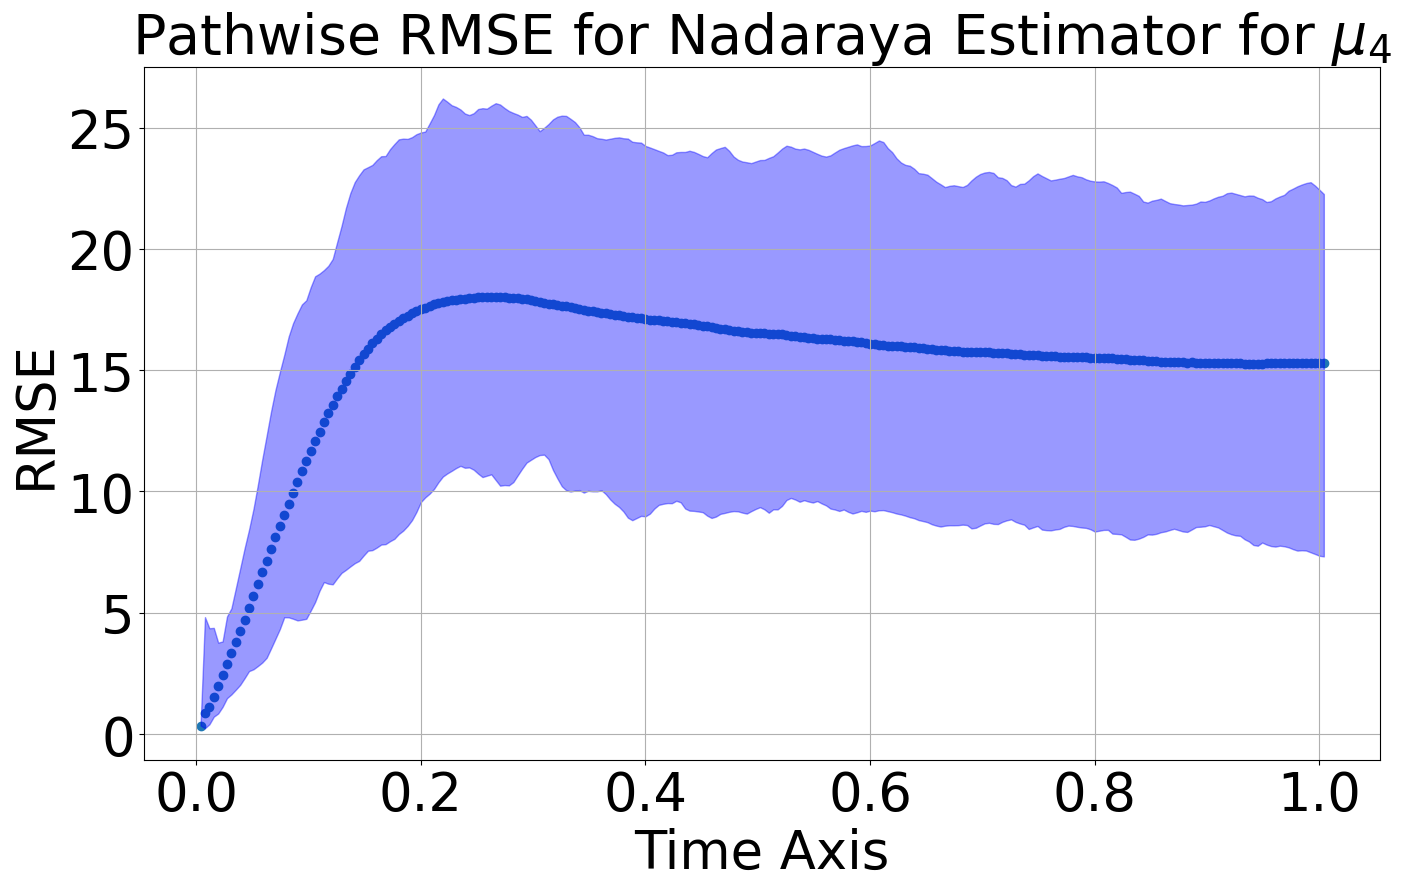

15.293380534345706 0.0031749 15.300784268647655


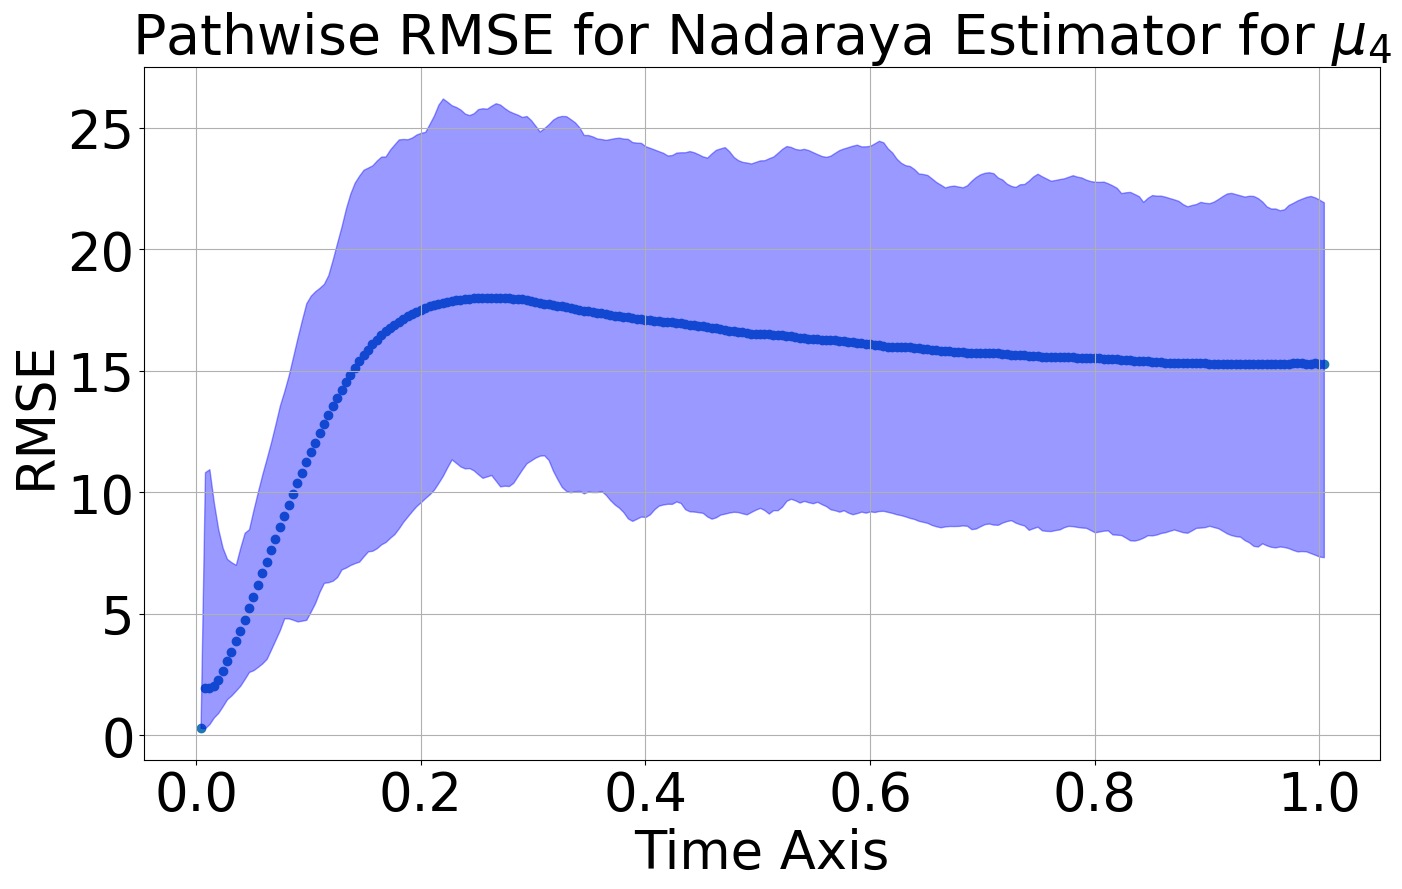

In [5]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if i == 1: continue
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_4$",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/12DDimsNS/IIDNadaraya_fBiPot_{config.ndims}DDims_DriftTrack_{round(bw, 6)}bw_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()

In [6]:
simpaths=all_local_states.reshape(-1, 257, 12)

In [7]:
true_paths=np.load(config.data_path, allow_pickle=True)[:num_paths, :]

In [8]:
markv=np.load("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/12DDimsNS/TSPM_MLP_ST_0010FTh_fBiPot_12DDimsNS_OOSDriftTrack_496Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_global_states.npy", allow_pickle=True).reshape(-1, 257, 12)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/12DDimsNS/TSPM_MLP_ST_0010FTh_fBiPot_12DDimsNS_OOSDriftTrack_496Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_global_states.npy'

In [ ]:
markv.shape

In [ ]:
plt.hist(simpaths[:, 1:, 10].flatten(), bins=150, alpha=0.6, density=True, color="orange", label="Nadaraya Sim")
plt.hist(markv[:, 1:, 10].flatten(), bins=150, alpha=0.6, density=True, color="green", label="Score Sim")
plt.hist(true_paths[:, 10].flatten(), bins=150,alpha=0.3,  density=True, color="blue", label="True")
plt.legend()